# 각 phase간 z방향 slice를 맞추는 루틴 파이프라인

In [1]:
import os, sys, re, shutil
import glob, natsort
from tqdm import tqdm
import SimpleITK as sitk
import pandas as pd
import numpy as np
import subprocess
import gui
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
%config Completer.use_jedi = False

/home/hahnyi/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


# liver slice만 남기기

In [2]:
ct_basepath = '../../data/'
samples = ['002', '004', '009', '010']

ct_arterys = []
ct_portals = []
ct_delays = []
mask_arterys = []
mask_portals = []
mask_delays = []
for sample in samples :
    ct_arterys.extend(glob.glob(os.path.join(ct_basepath, "ct_liver/artery/{}*_resize.hdr".format(sample))))
    ct_portals.extend(glob.glob(os.path.join(ct_basepath, "ct_liver/portal/{}*_resize.hdr".format(sample))))
    ct_delays.extend(glob.glob(os.path.join(ct_basepath, "ct_liver/delay/{}*_resize.hdr".format(sample))))
    
    mask_arterys.extend(glob.glob(os.path.join(ct_basepath, "mask_liver/artery/{}*_resize_Lg.hdr".format(sample))))
    mask_portals.extend(glob.glob(os.path.join(ct_basepath, "mask_liver/portal/{}*_resize_Lg.hdr".format(sample))))
    mask_delays.extend(glob.glob(os.path.join(ct_basepath, "mask_liver/delay/{}*_resize_Lg.hdr".format(sample))))
    
len(ct_arterys), len(ct_portals), len(ct_delays), len(mask_arterys), len(mask_portals), len(mask_delays)

(4, 4, 3, 4, 4, 3)

##### SimpleITK.WriteImage로 저장하기 전에 Set 해줘야하는 변수들
- SetSpacing
- SetOrigin
- SetDirection

In [3]:
sample_zslices_df = pd.DataFrame(columns = ['phases', 'sample', 'n_zslices', 'isMask', 'path'])

In [4]:
outpath_artery = "samples/cropped_CT/maskslices_only/artery"
os.makedirs(outpath_artery, exist_ok=True)
for i, mask_path in tqdm(enumerate(mask_arterys), total=len(mask_arterys)):
    fname = os.path.basename(ct_arterys[i]).replace('resize', 'onlyliver')
    sample_num = fname.split('_')[0]
    img_artery = sitk.ReadImage(ct_arterys[i])
    img_artery_arr = sitk.GetArrayFromImage(img_artery)
    mask_artery = sitk.ReadImage(mask_path)
    mask_artery_arr = sitk.GetArrayFromImage(mask_artery)
    
    ct_artery_slices = []
    for i in range(len(mask_artery_arr)):
        if len(mask_artery_arr[i][np.where(mask_artery_arr[i] > 0)]) != 0:
            ct_artery_slices.append(img_artery_arr[i])
    
    ct_artery = np.array(ct_artery_slices)
    crop_liver_img = sitk.GetImageFromArray(ct_artery)
    crop_liver_img.SetSpacing(img_artery.GetSpacing())
    crop_liver_img.SetOrigin(img_artery.GetOrigin())
    crop_liver_img.SetDirection(img_artery.GetDirection())
    sitk.WriteImage(crop_liver_img, os.path.join(outpath_artery, '{}.hdr'.format(fname)))
    sample_zslices_df.loc[len(sample_zslices_df)] = ['artery', sample_num, ct_artery.shape[0], False,
                                                     os.path.join(outpath_artery, '{}'.format(fname))]
    #sitk.WriteImage(crop_liver_img, f'./samples_new/cropped_CT/ARTERY/{fname}.hdr')

100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


In [5]:
sample_zslices_df

,phases,sample,n_zslices,isMask,path
0,artery,002,17,False,samples/cropped_CT/maskslices_only/artery/002_11007854_onlyliver.hdr
1,artery,004,30,False,samples/cropped_CT/maskslices_only/artery/004_11453440_onlyliver.hdr
2,artery,009,27,False,samples/cropped_CT/maskslices_only/artery/009_12136166_onlyliver.hdr
3,artery,010,30,False,samples/cropped_CT/maskslices_only/artery/010_12281624_onlyliver.hdr


In [6]:
outpath_portal = "samples/cropped_CT/maskslices_only/portal"
os.makedirs(outpath_portal, exist_ok=True)
for i, mask_path in tqdm(enumerate(mask_portals), total=len(mask_portals)):
    fname = os.path.basename(ct_portals[i]).replace('resize', 'onlyliver')
    sample_num = fname.split('_')[0]
    img_portal = sitk.ReadImage(ct_portals[i])
    img_portal_arr = sitk.GetArrayFromImage(img_portal)
    mask_portal = sitk.ReadImage(mask_path)
    mask_portal_arr = sitk.GetArrayFromImage(mask_portal)
    
    ct_portal_slices = []
    for i in range(len(mask_portal_arr)):
        if len(mask_portal_arr[i][np.where(mask_portal_arr[i] > 0)]) != 0:
            ct_portal_slices.append(img_portal_arr[i])
    
    ct_portal = np.array(ct_portal_slices)
    crop_liver_img = sitk.GetImageFromArray(ct_portal)
    crop_liver_img.SetSpacing(img_portal.GetSpacing())
    crop_liver_img.SetOrigin(img_portal.GetOrigin())
    crop_liver_img.SetDirection(img_portal.GetDirection())
    sitk.WriteImage(crop_liver_img, os.path.join(outpath_portal, '{}.hdr'.format(fname)))
    sample_zslices_df.loc[len(sample_zslices_df)] = ['portal', sample_num, ct_portal.shape[0], False, 
                                                    os.path.join(outpath_portal, '{}'.format(fname))]
    #sitk.WriteImage(crop_liver_img, f'./samples_new/cropped_CT/PORTAL/{fname}.hdr')

100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


In [7]:
outpath_delay = "samples/cropped_CT/maskslices_only/delay"
os.makedirs(outpath_delay, exist_ok=True)
for i, mask_path in tqdm(enumerate(mask_delays), total=len(mask_delays)):
    fname = os.path.basename(ct_delays[i]).replace('resize', 'onlyliver')
    sample_num = fname.split('_')[0]
    img_delay = sitk.ReadImage(ct_delays[i])
    img_delay_arr = sitk.GetArrayFromImage(img_delay)
    mask_delay = sitk.ReadImage(mask_path)
    mask_delay_arr = sitk.GetArrayFromImage(mask_delay)
    
    ct_delay_slices = []
    for i in range(len(mask_delay_arr)):
        if len(mask_delay_arr[i][np.where(mask_delay_arr[i] > 0)]) != 0:
            ct_delay_slices.append(img_delay_arr[i])
    
    ct_delay = np.array(ct_delay_slices)
    crop_liver_img = sitk.GetImageFromArray(ct_delay)
    crop_liver_img.SetSpacing(img_delay.GetSpacing())
    crop_liver_img.SetOrigin(img_delay.GetOrigin())
    crop_liver_img.SetDirection(img_delay.GetDirection())
    sitk.WriteImage(crop_liver_img, os.path.join(outpath_delay, '{}.hdr'.format(fname)))
    sample_zslices_df.loc[len(sample_zslices_df)] = ['delay', sample_num, ct_delay.shape[0], False, 
                                                    os.path.join(outpath_delay, '{}'.format(fname))]
#     sitk.WriteImage(crop_liver_img, f'./samples_new/cropped_CT/DELAY/{fname}.hdr')

100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


#### phase 간 (artery와 portal / delay와 portal) slice 개수를 crop한 마스크

In [8]:
outpath_artery = "samples/cropped_MASK/maskslices_only/artery"
os.makedirs(outpath_delay, exist_ok=True)
for i, mask_path in tqdm(enumerate(mask_arterys), total=len(mask_arterys)):
    fname = os.path.basename(mask_path).replace('resize_Lg', 'onlyliver')
    sample_num = fname.split('_')[0]
    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)
    
    mask_arr_slices = []
    for i in range(len(mask_arr)):
        if len(mask_arr[i][np.where(mask_arr[i] > 0)]) != 0:
            mask_arr_slices.append(mask_arr[i])
            
    
    mask_artery = np.array(mask_arr_slices)
    only_liver_img = sitk.GetImageFromArray(mask_artery)
    only_liver_img.SetSpacing(mask_img.GetSpacing())
    only_liver_img.SetOrigin(mask_img.GetOrigin())
    only_liver_img.SetDirection(mask_img.GetDirection())
    sitk.WriteImage(only_liver_img, f'./samples/cropped_MASK/maskslices_only/artery/{fname}.hdr')
    sample_zslices_df.loc[len(sample_zslices_df)] = ['artery', sample_num, mask_artery.shape[0], True, 
                                                    f'./samples/cropped_MASK/maskslices_only/artery/{fname}']

100%|██████████| 4/4 [00:00<00:00,  7.08it/s]


In [9]:
outpath_portal = "samples/cropped_MASK/maskslices_only/portal"
os.makedirs(outpath_delay, exist_ok=True)
for i, mask_path in tqdm(enumerate(mask_portals), total=len(mask_portals)):
    fname = os.path.basename(mask_path).replace('resize_Lg', 'onlyliver')
    sample_num = fname.split('_')[0]
    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)
    
    mask_arr_slices = []
    for i in range(len(mask_arr)):
        if len(mask_arr[i][np.where(mask_arr[i] > 0)]) != 0:
            mask_arr_slices.append(mask_arr[i])
    
    mask_portal = np.array(mask_arr_slices)
    only_liver_img = sitk.GetImageFromArray(mask_portal)
    only_liver_img.SetSpacing(mask_img.GetSpacing())
    only_liver_img.SetOrigin(mask_img.GetOrigin())
    only_liver_img.SetDirection(mask_img.GetDirection())
    sitk.WriteImage(only_liver_img, f'./samples/cropped_MASK/maskslices_only/portal/{fname}.hdr')
    sample_zslices_df.loc[len(sample_zslices_df)] = ['portal', sample_num, mask_portal.shape[0], True, 
                                                    f'./samples/cropped_MASK/maskslices_only/portal/{fname}']

100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


In [10]:
outpath_delay = "samples/cropped_MASK/maskslices_only/delay"
os.makedirs(outpath_delay, exist_ok=True)
for i, mask_path in tqdm(enumerate(mask_delays), total=len(mask_delays)):
    fname = os.path.basename(mask_path).replace('resize_Lg', 'onlyliver')
    sample_num = fname.split('_')[0]
    mask_img = sitk.ReadImage(mask_path)
    mask_arr = sitk.GetArrayFromImage(mask_img)
    
    mask_arr_slices = []
    for i in range(len(mask_arr)):
        if len(mask_arr[i][np.where(mask_arr[i] > 0)]) != 0:
            mask_arr_slices.append(mask_arr[i])
    
    mask_delay = np.array(mask_arr_slices)
    only_liver_img = sitk.GetImageFromArray(mask_delay)
    only_liver_img.SetSpacing(mask_img.GetSpacing())
    only_liver_img.SetOrigin(mask_img.GetOrigin())
    only_liver_img.SetDirection(mask_img.GetDirection())
    sitk.WriteImage(only_liver_img, f'./samples/cropped_MASK/maskslices_only/delay/{fname}.hdr')
    sample_zslices_df.loc[len(sample_zslices_df)] = ['delay', sample_num, mask_delay.shape[0], True, 
                                                    f'./samples/cropped_MASK/maskslices_only/delay/{fname}']

100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


In [11]:
sample_zslices_df

,phases,sample,n_zslices,isMask,path
0,artery,002,17,False,samples/cropped_CT/maskslices_only/artery/002_11007854_onlyliver.hdr
1,artery,004,30,False,samples/cropped_CT/maskslices_only/artery/004_11453440_onlyliver.hdr
2,artery,009,27,False,samples/cropped_CT/maskslices_only/artery/009_12136166_onlyliver.hdr
3,artery,010,30,False,samples/cropped_CT/maskslices_only/artery/010_12281624_onlyliver.hdr
4,portal,002,17,False,samples/cropped_CT/maskslices_only/portal/002_11007854_onlyliver.hdr
5,portal,004,31,False,samples/cropped_CT/maskslices_only/portal/004_11453440_onlyliver.hdr
6,portal,009,27,False,samples/cropped_CT/maskslices_only/portal/009_12136166_onlyliver.hdr
7,portal,010,30,False,samples/cropped_CT/maskslices_only/portal/010_12281624_onlyliver.hdr
8,delay,004,27,False,samples/cropped_CT/maskslices_only/delay/004_11453440_onlyliver.hdr
9,delay,009,28,False,samples/cropped_CT/maskslices_only/delay/009_12136166_onlyliver.hdr


In [12]:
def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if  components_per_pixel == 1:
        return mask*image
    else:
        return sitk.Compose([mask*sitk.VectorIndexSelectionCast(image,channel) \
                             for channel in range(components_per_pixel)])

#### The intensity histogram of masked area in Liver CT according to sample and phase

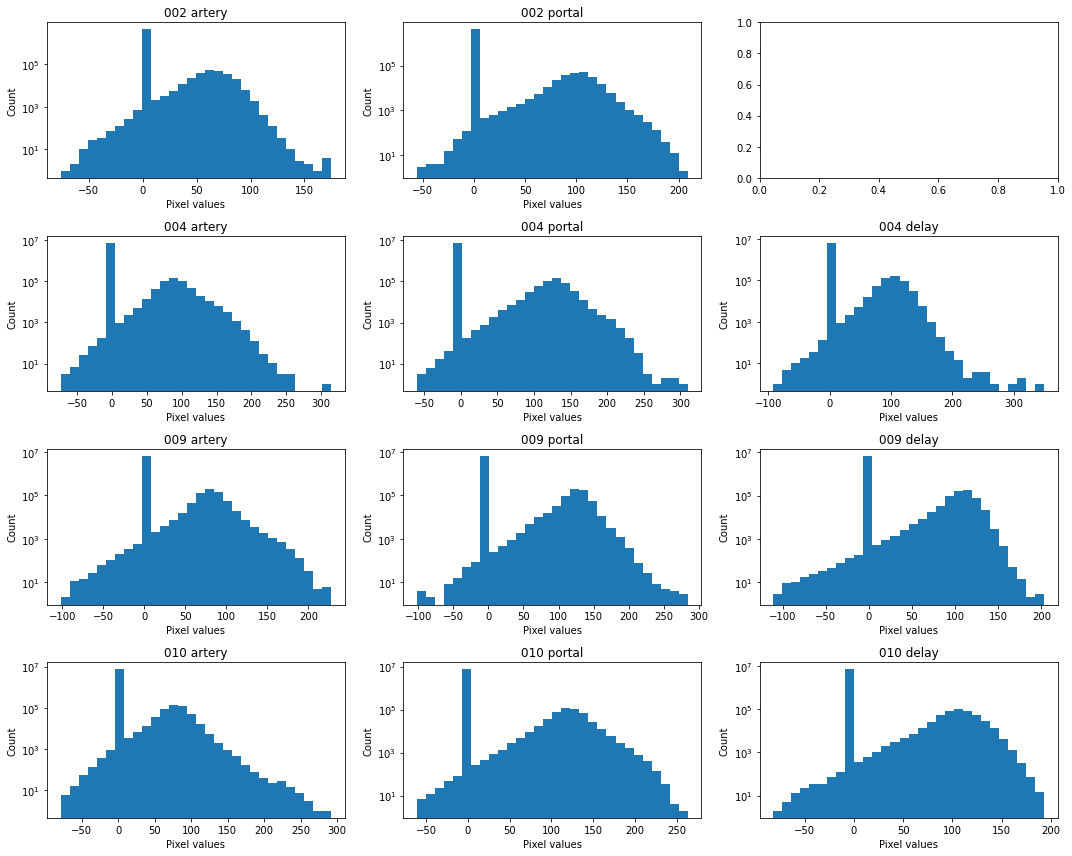

In [13]:
phases = ['artery', 'portal', 'delay']
fig, ax = plt.subplots(4, 3, figsize=(15, 12))
for i, sample in enumerate(samples) :
    for j, phase in enumerate(phases) :
        sample_data = sample_zslices_df[(sample_zslices_df['phases']==phase) &
                                        (sample_zslices_df['sample']==sample)]
        sample_data = sample_data.reset_index()
        if sample_data.shape[0] == 2:
            sample_image = sample_data[sample_data['isMask']==False].loc[0, 'path']
            sample_mask = sample_data[sample_data['isMask']==True].loc[1, 'path']
            image = sitk.Cast(sitk.ReadImage(sample_image), sitk.sitkFloat64)
            mask = sitk.Cast(sitk.ReadImage(sample_mask), sitk.sitkFloat64)
            masked_image = mask_image_multiply(mask, image)
            masked_image_arr = sitk.GetArrayFromImage(masked_image)
            ax[i, j].hist(masked_image_arr.flatten(), bins=30)
            ax[i, j].set_yscale('log')
            ax[i, j].set_xlabel('Pixel values')
            ax[i, j].set_ylabel('Count')
            ax[i, j].set_title(str(sample) + " " +str(phase))
plt.tight_layout()

In [15]:
out_basepath = 'mask_region_only'
samples = ['002', '004', '009', '010']
#samples = ['002']
mv_phases = ['artery', 'delay']
for i, sample in enumerate(samples) :
    fix_data = sample_zslices_df[(sample_zslices_df['sample']==sample)&
                                (sample_zslices_df['phases']=='portal')]
    fix_data = fix_data.reset_index()
    if fix_data.shape[0] == 2 :
        fix_imagefile = fix_data[fix_data['isMask']==False].loc[0, 'path']
        fix_maskfile = fix_data[fix_data['isMask']==True].loc[1, 'path']
    for j, mv_phase in enumerate(mv_phases) :
        move_data = sample_zslices_df[(sample_zslices_df['sample']==sample) & 
                                     (sample_zslices_df['phases']==mv_phase)]
        move_data = move_data.reset_index()
        if move_data.shape[0] == 2 :
            move_imagefile = move_data[move_data['isMask']==False].loc[0, 'path']
            move_maskfile = move_data[move_data['isMask']==True].loc[1, 'path']
#             print(move_imagefile, move_maskfile, fix_imagefile, fix_maskfile)
            out_dirname = os.path.join(out_basepath, sample+'/'+mv_phase+'2portal_ab')
            print(sample, mv_phase, out_dirname)
            #sys.exit(-1)
            os.makedirs(out_dirname, exist_ok=True)
            out = subprocess.Popen(['elastix', 
                                    '-f', fix_imagefile, 
                                    '-m', move_imagefile, 
                                    '-p', 'affine_params.txt', '-p', 'bspline_params.txt', 
                                    '-out', out_dirname, 
                                    '-fMask', fix_maskfile,
                                    '-mMask', move_maskfile,
                                    '-threads', '96'], stdout=subprocess.PIPE).communicate()[0]
            if os.path.isdir(out_dirname) :
                if not os.path.isfile(os.path.join(out_dirname, 'result.1.mha')) :
                    if os.path.isfile(os.path.join(out_dirname, 'result.0.mha')) :
                        os.rename(out_dirname, os.path.join(out_basepath, sample+'/'+mv_phase+'2portal_a'))
                    else :
                        print("registration failure!")
                        shutil.rmtree(out_dirname)

002 artery mask_region_only/002/artery2portal_ab
004 artery mask_region_only/004/artery2portal_ab
004 delay mask_region_only/004/delay2portal_ab
009 artery mask_region_only/009/artery2portal_ab
009 delay mask_region_only/009/delay2portal_ab
010 artery mask_region_only/010/artery2portal_ab
010 delay mask_region_only/010/delay2portal_ab
